# Lindsey's Initial Data Exploration and Models

In [119]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_auc_score, plot_confusion_matrix

import xgboost as xgb

Additional library for additional encoders: https://contrib.scikit-learn.org/category_encoders/

In [2]:
import category_encoders as ce

In [ ]:
# Command to install category_encoders if you'd like to use it:
# !conda install -c conda-forge category_encoders

In [116]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, roc_auc='skip'):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score
    
    Inputs:
        estimator: a fit sklearn-style model or pipeline
        X_tr: array or pandas dataframe
            training input variables
        X_te: array or pandas dataframe
            testing input variables
        y_tr: array or pandas series
            training output variable
        y_te: array or pandas series
            testing output variable
        roc_auc: str
            'skip': default, skips calculating roc_auc
            'dec': use decision_function to calculate roc_auc
            'proba': use predict_proba to calculate roc_auc
            
    '''
    # Grab predictions
    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': 
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba': 
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'")    
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
    if type(test_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_te, y_te, values_format='.5g')

## Business Understanding

End Users:


Business Problem Summary:


Context:

- False negative in this context: 
    - Outcome: 
- False positive in this context: 
    - Outcome: 
    
Evaluation:

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [9]:
!ls ../..

README.md data      notebooks


In [5]:
!ls ../../data

cat_in_the_dat2_train.csv


In [3]:
df = pd.read_csv("../../data/cat_in_the_dat2_train.csv", index_col='id')

In [4]:
df.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bin_0   582106 non-null  float64
 1   bin_1   581997 non-null  float64
 2   bin_2   582070 non-null  float64
 3   bin_3   581986 non-null  object 
 4   bin_4   581953 non-null  object 
 5   nom_0   581748 non-null  object 
 6   nom_1   581844 non-null  object 
 7   nom_2   581965 non-null  object 
 8   nom_3   581879 non-null  object 
 9   nom_4   581965 non-null  object 
 10  nom_5   582222 non-null  object 
 11  nom_6   581869 non-null  object 
 12  nom_7   581997 non-null  object 
 13  nom_8   582245 non-null  object 
 14  nom_9   581927 non-null  object 
 15  ord_0   581712 non-null  float64
 16  ord_1   581959 non-null  object 
 17  ord_2   581925 non-null  object 
 18  ord_3   582084 non-null  object 
 19  ord_4   582070 non-null  object 
 20  ord_5   582287 non-null  object 
 21  day     58

In [6]:
# Exploring numeric cols
df.describe()

,bin_0,bin_1,bin_2,ord_0,day,month,target
count,582106.000000,581997.000000,582070.000000,581712.000000,582048.000000,582012.000000,600000.000000
mean,0.092301,0.185532,0.278704,1.948224,4.112767,6.371317,0.187205
std,0.289451,0.388729,0.448362,0.853904,2.034430,3.458959,0.390076
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000
50%,0.000000,0.000000,0.000000,2.000000,5.000000,6.000000,0.000000
75%,0.000000,0.000000,1.000000,3.000000,6.000000,8.000000,0.000000
max,1.000000,1.000000,1.000000,3.000000,7.000000,12.000000,1.000000


In [68]:
# Define our X and y

X = df.drop(columns=['target'])
y = df['target']

# Create our holdout set!
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.1,  # saving 10%
                                                random_state=0)
# Then a regular train/test split
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.2,
                                                    random_state=0)

In [71]:
# Exploring numeric cols
X_train.describe()

,bin_0,bin_1,bin_2,ord_0,day,month
count,419124.000000,418949.000000,419065.000000,418808.000000,418998.000000,419057.000000
mean,0.092364,0.185743,0.278876,1.948100,4.112779,6.373579
std,0.289540,0.388900,0.448447,0.853954,2.034446,3.458282
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000
50%,0.000000,0.000000,0.000000,2.000000,5.000000,6.000000
75%,0.000000,0.000000,1.000000,3.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,3.000000,7.000000,12.000000


In [74]:
# Exploring object cols
X_train[[c for c in X_train.columns if X_train[c].dtype == 'object']].describe()

,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_1,ord_2,ord_3,ord_4,ord_5
count,419024,418962,418839,418952,418953,418924,418978,419285,418939,419049,419215,419000,419023,418957,419092,419126,419316
unique,2,2,3,6,6,6,4,1219,1518,222,222,2218,5,6,15,26,190
top,F,N,Red,Triangle,Hamster,India,Theremin,4d701cd2a,b88220966,c79d2197d,15f03b1f4,483535452,Novice,Freezing,n,N,Fl
freq,263529,224731,233109,118289,118856,118636,222212,706,590,3620,3635,418,115272,102751,51085,28664,7671


In [72]:
# Exploring target distribution
y_train.value_counts(normalize=True)

0    0.812787
1    0.187213
Name: target, dtype: float64

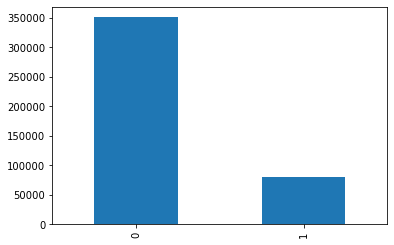

In [73]:
y_train.value_counts().plot(kind='bar');

### Pipeline Pre-Processor Set Up:

Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

First model: Decision Tree

Define a Pipeline strategy:

- Impute - on all columns (all inputs have null values)
    - Numerics: fill with median
    - Categoricals: fill with "Unknown"
- Different strategies for numeric and categorical:
    - Numerics: nothing! don't need to scale
    - Categorical: encode!
        - How many uniques per column?
            - < 10 --> OHE
            - \> 10 --> Frequency encode


In [24]:
len(X_train['nom_5'].unique())

1220

In [25]:
X_train['nom_5'].nunique()

1219

In [75]:
# Set up lists for columns requiring different treatment
num_cols = []
ohe_cols = []
freq_cols = []

for c in X_train.columns:
    if X_train[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X_train[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [76]:
print(num_cols)
print(ohe_cols)
print(freq_cols)

['bin_0', 'bin_1', 'bin_2', 'ord_0', 'day', 'month']
['bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'ord_1', 'ord_2']
['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_3', 'ord_4', 'ord_5']


In [77]:
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median'))
    ])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('oh_encoder', OneHotEncoder(handle_unknown='ignore'))
])

freq_transformer = Pipeline(steps=[
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)),
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0))
])

In [78]:
# Package those pieces together using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])

In [79]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['bin_0', 'bin_1', 'bin_2', 'ord_0', 'day',
                                  'month']),
                                ('ohe',
                                 Pipeline(steps=[('ohe_imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('oh_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
                                  'nom_3', 'nom_4', 'ord_1', 'ord_2']),
                                ('freq',
                                 Pipeline(steps=[('freq_enc

### Single Decision Tree

In [94]:
clf_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [95]:
cross_validate(clf_dt, X_train, y_train, return_train_score=True)

{'fit_time': array([9.4162817 , 9.49889493, 9.31076217, 9.5733912 , 9.39399695]),
 'score_time': array([0.39556408, 0.39229918, 0.46105313, 0.43496895, 0.44970107]),
 'test_score': array([0.70921296, 0.71025463, 0.71068287, 0.71116898, 0.71111111]),
 'train_score': array([1., 1., 1., 1., 1.])}

#### Grid Search for Single DT

In [96]:
param_grid = {
    "classifier__max_depth": [1, 5, 10],
    "classifier__min_samples_split": [2, 10, 100]
}

In [97]:
grid = GridSearchCV(clf_dt, param_grid, scoring='f1')

In [98]:
output = grid.fit(X_train, y_train)

In [99]:
output.best_params_

{'classifier__max_depth': 10, 'classifier__min_samples_split': 10}

Training Scores:
Train Accuracy: 0.8169212962962963
Train Precision: 0.6264156285390714
Train Recall: 0.054713388397052275
Train F1-Score: 0.10063679781669319
ROC-AUC: 0.6962222524929416
**********
Testing Scores:
Test Accuracy: 0.8096574074074074
Test Precision: 0.4534368070953437
Test Recall: 0.04011967237235765
Test F1-Score: 0.07371693777317173
ROC-AUC: 0.6730284034113609


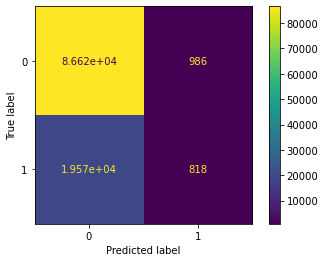

In [100]:
evaluate(output.best_estimator_, X_train, X_test, y_train, y_test, roc_auc='proba')

### XGBoost

(not gonna tune or play with this much, just want to showcase it)

In [175]:
clf_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=1))
])

In [125]:
cross_validate(clf_xgb, X_train, y_train, return_train_score=True)

{'fit_time': array([34.13187528, 33.27506399, 34.49278975, 41.64173603, 35.23237705]),
 'score_time': array([0.62003779, 0.59619188, 0.63012719, 0.69484997, 0.60381293]),
 'test_score': array([0.81815972, 0.81976852, 0.81945602, 0.8187037 , 0.81934028]),
 'train_score': array([0.82947338, 0.82839699, 0.82880498, 0.82883681, 0.82925058])}

Training Scores:
Train Accuracy: 0.8276736111111112
Train Precision: 0.6763754045307443
Train Recall: 0.15246797566645234
Train F1-Score: 0.24884216049320432
**********
Testing Scores:
Test Accuracy: 0.8179722222222222
Test Precision: 0.5824299909665763
Test Recall: 0.12648977389768992
Test F1-Score: 0.20784139904097998


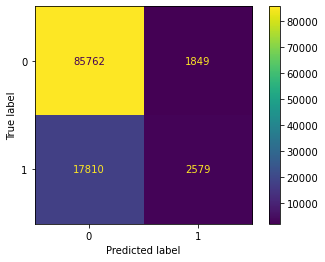

In [177]:
clf_xgb.fit(X_train, y_train)
evaluate(clf_xgb, X_train, X_test, y_train, y_test, roc_auc='skip')

### Random Forest

In [109]:
clf_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced'))
])

In [110]:
cross_validate(clf_rf, X_train, y_train, return_train_score=True)

{'fit_time': array([64.84280777, 63.36052799, 63.22052503, 62.85519409, 63.08557606]),
 'score_time': array([3.11946917, 2.77172494, 2.7593081 , 2.76300097, 2.85535812]),
 'test_score': array([0.81327546, 0.81355324, 0.81328704, 0.81327546, 0.81326389]),
 'train_score': array([0.99999132, 0.99999711, 0.99999132, 1.        , 0.99998553])}

In [111]:
param_grid = {
    "classifier__max_depth": [3, 5],
    "classifier__max_samples": [.5, None]
}

In [112]:
grid = GridSearchCV(clf_rf, param_grid, scoring='f1')

In [113]:
output = grid.fit(X_train, y_train)

In [114]:
output.best_params_

{'classifier__max_depth': 5, 'classifier__max_samples': 0.5}

Training Scores:
Train Accuracy: 0.6299212962962963
Train Precision: 0.28349357041844353
Train Recall: 0.6394975023492754
Train F1-Score: 0.3928389679242274
ROC-AUC: 0.6864781265331505
**********
Testing Scores:
Test Accuracy: 0.6304814814814815
Test Precision: 0.2859993421773928
Test Recall: 0.6397076855167002
Test F1-Score: 0.3952783586386641
ROC-AUC: 0.6856260930190241


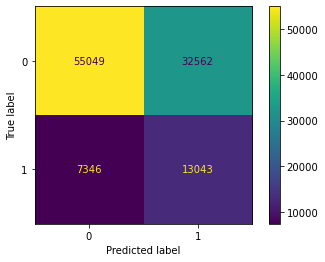

In [117]:
evaluate(output.best_estimator_, X_train, X_test, y_train, y_test, roc_auc='proba')

### Exploring Feature Importance

In [178]:
clf_rf['preprocessor']

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['bin_0', 'bin_1', 'bin_2', 'ord_0', 'day',
                                  'month']),
                                ('ohe',
                                 Pipeline(steps=[('ohe_imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('oh_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
                                  'nom_3', 'nom_4', 'ord_1', 'ord_2']),
                                ('freq',
                                 Pipeline(steps=[('freq_enc

In [181]:
X_train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
380569,0.0,0.0,NaN,F,N,Red,Circle,Hamster,Finland,Piano,...,d5a47d599,114fa41d7,3.0,Master,Boiling Hot,d,B,Rj,5.0,8.0
126835,0.0,1.0,0.0,F,N,Red,Trapezoid,Axolotl,Russia,Theremin,...,4abb8589e,243898b48,NaN,NaN,Cold,i,E,Rj,7.0,2.0
489645,0.0,1.0,0.0,F,Y,Blue,Polygon,Dog,Costa Rica,Bassoon,...,745b909d1,28cf0df98,3.0,Master,Hot,m,H,AU,5.0,8.0
50407,0.0,0.0,1.0,F,Y,Blue,Circle,Dog,Russia,Theremin,...,6f853fd13,d94436c6e,2.0,Master,Freezing,n,H,XC,1.0,12.0
588222,0.0,0.0,0.0,T,N,Blue,Polygon,Axolotl,Russia,Theremin,...,1fe15a999,437461112,3.0,Expert,Lava Hot,f,Y,NaN,2.0,12.0


In [210]:
# let's do our final pipeline with different hyperparameters
clf_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced',
                                          max_depth= 5, 
                                          max_samples= 0.5))
])

clf_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['bin_0', 'bin_1', 'bin_2',
                                                   'ord_0', 'day', 'month']),
                                                 ('ohe',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('oh_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                               

In [235]:
# what are we looking for? how many columns is our transformed data?
clf_final['preprocessor'].fit_transform(X_train).shape

(432000, 63)

In [236]:
pd.DataFrame(clf_final['preprocessor'].fit_transform(X_train)).head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0.0,0.0,0.0,3.0,5.0,8.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.001025,0.001053,0.007854,0.003391,0.000382,0.050986,0.373250,0.005778
1,0.0,1.0,0.0,2.0,7.0,2.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.001565,0.000634,0.005627,0.002891,0.000792,0.058201,0.373250,0.005778
2,0.0,1.0,0.0,3.0,5.0,8.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.001407,0.000988,0.007167,0.007164,0.000294,0.096634,0.051998,0.007509
3,0.0,0.0,1.0,2.0,1.0,12.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.001074,0.000782,0.007014,0.004884,0.000722,0.118252,0.051998,0.009014
4,0.0,0.0,0.0,3.0,2.0,12.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.000944,0.000572,0.005870,0.004743,0.000715,0.100315,0.061451,0.029361


In [211]:
# how to get feature importances from your classifier
clf_final['classifier'].feature_importances_

array([5.51595115e-02, 5.65053813e-04, 4.61085812e-02, 1.74198256e-01,
       7.13261646e-03, 1.78791682e-01, 5.55745957e-05, 7.28318772e-05,
       1.34560726e-05, 3.56187394e-04, 3.17110975e-05, 5.89793276e-04,
       2.55844242e-04, 6.00780737e-05, 5.23481432e-05, 2.68875410e-05,
       1.20496995e-04, 4.17041256e-03, 3.12739379e-04, 2.70645367e-03,
       2.03172060e-02, 1.88418720e-02, 1.14727036e-04, 8.08873690e-04,
       2.50482940e-04, 5.79951964e-05, 2.97736715e-03, 3.89168626e-03,
       2.36767646e-04, 7.51732227e-05, 3.26558077e-04, 1.43505786e-03,
       1.66465981e-03, 6.29125292e-05, 1.03133167e-02, 1.16653877e-02,
       1.89158738e-05, 5.42665863e-03, 8.51354090e-05, 2.57657401e-03,
       8.49110112e-04, 1.24339215e-04, 1.24589256e-03, 1.14126052e-04,
       2.05352022e-02, 2.09200570e-03, 1.93834094e-02, 8.14691093e-05,
       4.90668831e-02, 1.58108035e-02, 8.08377032e-02, 2.15610672e-03,
       1.01443055e-01, 3.49974179e-05, 1.67294012e-03, 1.06532459e-03,
      

In [212]:
clf_final['preprocessor']

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['bin_0', 'bin_1', 'bin_2', 'ord_0', 'day',
                                  'month']),
                                ('ohe',
                                 Pipeline(steps=[('ohe_imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('oh_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
                                  'nom_3', 'nom_4', 'ord_1', 'ord_2']),
                                ('freq',
                                 Pipeline(steps=[('freq_enc

In [217]:
clf_final['preprocessor'].transformers_[0][2]

['bin_0', 'bin_1', 'bin_2', 'ord_0', 'day', 'month']

In [218]:
num_cols

['bin_0', 'bin_1', 'bin_2', 'ord_0', 'day', 'month']

In [221]:
ohe_cols_transformed = clf_final['preprocessor'].transformers_[1][1]['oh_encoder'].get_feature_names(ohe_cols)
ohe_cols_transformed

array(['bin_3_F', 'bin_3_T', 'bin_3_Unknown', 'bin_4_N', 'bin_4_Unknown',
       'bin_4_Y', 'nom_0_Blue', 'nom_0_Green', 'nom_0_Red',
       'nom_0_Unknown', 'nom_1_Circle', 'nom_1_Polygon', 'nom_1_Square',
       'nom_1_Star', 'nom_1_Trapezoid', 'nom_1_Triangle', 'nom_1_Unknown',
       'nom_2_Axolotl', 'nom_2_Cat', 'nom_2_Dog', 'nom_2_Hamster',
       'nom_2_Lion', 'nom_2_Snake', 'nom_2_Unknown', 'nom_3_Canada',
       'nom_3_China', 'nom_3_Costa Rica', 'nom_3_Finland', 'nom_3_India',
       'nom_3_Russia', 'nom_3_Unknown', 'nom_4_Bassoon', 'nom_4_Oboe',
       'nom_4_Piano', 'nom_4_Theremin', 'nom_4_Unknown',
       'ord_1_Contributor', 'ord_1_Expert', 'ord_1_Grandmaster',
       'ord_1_Master', 'ord_1_Novice', 'ord_1_Unknown',
       'ord_2_Boiling Hot', 'ord_2_Cold', 'ord_2_Freezing', 'ord_2_Hot',
       'ord_2_Lava Hot', 'ord_2_Unknown', 'ord_2_Warm'], dtype=object)

In [224]:
clf_final['preprocessor'].transformers_[2][2]

['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_3', 'ord_4', 'ord_5']

In [225]:
freq_cols

['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_3', 'ord_4', 'ord_5']

In [227]:
final_cols = [*num_cols, *ohe_cols_transformed, *freq_cols]
final_cols

['bin_0',
 'bin_1',
 'bin_2',
 'ord_0',
 'day',
 'month',
 'bin_3_F',
 'bin_3_T',
 'bin_3_Unknown',
 'bin_4_N',
 'bin_4_Unknown',
 'bin_4_Y',
 'nom_0_Blue',
 'nom_0_Green',
 'nom_0_Red',
 'nom_0_Unknown',
 'nom_1_Circle',
 'nom_1_Polygon',
 'nom_1_Square',
 'nom_1_Star',
 'nom_1_Trapezoid',
 'nom_1_Triangle',
 'nom_1_Unknown',
 'nom_2_Axolotl',
 'nom_2_Cat',
 'nom_2_Dog',
 'nom_2_Hamster',
 'nom_2_Lion',
 'nom_2_Snake',
 'nom_2_Unknown',
 'nom_3_Canada',
 'nom_3_China',
 'nom_3_Costa Rica',
 'nom_3_Finland',
 'nom_3_India',
 'nom_3_Russia',
 'nom_3_Unknown',
 'nom_4_Bassoon',
 'nom_4_Oboe',
 'nom_4_Piano',
 'nom_4_Theremin',
 'nom_4_Unknown',
 'ord_1_Contributor',
 'ord_1_Expert',
 'ord_1_Grandmaster',
 'ord_1_Master',
 'ord_1_Novice',
 'ord_1_Unknown',
 'ord_2_Boiling Hot',
 'ord_2_Cold',
 'ord_2_Freezing',
 'ord_2_Hot',
 'ord_2_Lava Hot',
 'ord_2_Unknown',
 'ord_2_Warm',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9',
 'ord_3',
 'ord_4',
 'ord_5']

In [237]:
# putting together the final cols and the feature importances!
# plus sorting by feature importances
pd.DataFrame.from_dict(dict(zip(final_cols, clf_final['classifier'].feature_importances_)), 
                       orient='index').sort_values(by=0, ascending=False)

,0
month,0.178792
ord_0,0.174198
ord_3,0.142241
ord_2_Lava Hot,0.101443
ord_2_Freezing,0.080838
...,...
ord_2_Unknown,0.000035
bin_4_Unknown,0.000032
nom_0_Unknown,0.000027
nom_3_Unknown,0.000019


In [233]:
pd.DataFrame(clf_final['preprocessor'].fit_transform(X_train), columns=final_cols).head()

,bin_0,bin_1,bin_2,ord_0,day,month,bin_3_F,bin_3_T,bin_3_Unknown,bin_4_N,...,ord_2_Unknown,ord_2_Warm,nom_5,nom_6,nom_7,nom_8,nom_9,ord_3,ord_4,ord_5
0,0.0,0.0,0.0,3.0,5.0,8.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.001025,0.001053,0.007854,0.003391,0.000382,0.050986,0.373250,0.005778
1,0.0,1.0,0.0,2.0,7.0,2.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.001565,0.000634,0.005627,0.002891,0.000792,0.058201,0.373250,0.005778
2,0.0,1.0,0.0,3.0,5.0,8.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.001407,0.000988,0.007167,0.007164,0.000294,0.096634,0.051998,0.007509
3,0.0,0.0,1.0,2.0,1.0,12.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.001074,0.000782,0.007014,0.004884,0.000722,0.118252,0.051998,0.009014
4,0.0,0.0,0.0,3.0,2.0,12.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.000944,0.000572,0.005870,0.004743,0.000715,0.100315,0.061451,0.029361


### Permutation Importance

[Added directly into SKLearn V1.0!](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)

Or, with the old version of SKLearn, ELI5: https://eli5.readthedocs.io/en/latest/index.html

Tutorial using ELI5: https://www.kaggle.com/dansbecker/permutation-importance

In [234]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
# To install if you need:
# conda install -c conda-forge eli5

In [ ]:
X_train_transformed = clf_rf['preprocessor'].fit_transform(X_train)

perm = PermutationImportance(clf_rf['classifier'], random_state=1).fit(X_train_transformed, y_train)

In [174]:
eli5.show_weights(perm, feature_names = processed_columns)

Weight,Feature
0.1082 ± 0.0004,ord_0
0.0931 ± 0.0006,month
0.0839 ± 0.0004,ord_3
0.0707 ± 0.0006,bin_2
0.0541 ± 0.0007,ord_2_Freezing
0.0532 ± 0.0006,ord_1_Novice
0.0416 ± 0.0004,nom_1_Triangle
0.0412 ± 0.0005,day
0.0386 ± 0.0002,nom_1_Trapezoid
0.0378 ± 0.0001,ord_2_Lava Hot
